In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
os.chdir("../src")

from gpg.models.exponential_smoothing import ExponentialSmoothingForecaster
from gpg.model_selection.cross_validation import CrossValidationExperiment

In [8]:
# Constants
FILE_PATH = "/Users/lukasmalms/Desktop/DataScience/GitHub/german-power-grid/data/de-50hertz-demand-data.csv"
VAL_SIZE = 0.25
HORIZON = int(4*24*2)

In [6]:
# Import data
df = pd.read_csv(
    FILE_PATH, index_col=0, parse_dates=True
).astype({
    "quantity": np.float32
}).rename(columns={
    "quantity": "local_demand"
})

# Set frequency
df.index.freq = df.index.inferred_freq

# View head
df.head()

,local_demand
timestamp,
2014-12-31 23:00:00+00:00,9275.0
2014-12-31 23:15:00+00:00,9240.0
2014-12-31 23:30:00+00:00,9204.0
2014-12-31 23:45:00+00:00,9127.0
2015-01-01 00:00:00+00:00,9080.0


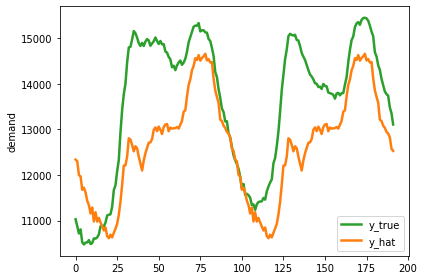

In [22]:
# Exponential smoothing forecaster

# Train / validation split
n_train = int(len(df) * (1 - VAL_SIZE))
df_train, df_val = df.iloc[:n_train], df.iloc[n_train:]
y_train, y_val = df_train["local_demand"].to_numpy(), df_val["local_demand"].to_numpy()

# Shorten y_train slighty
y_train = y_train[-int(2*30*4*24):]

# Initialise forecaster
forecaster = ExponentialSmoothingForecaster(
    has_trend=False,
    trend_is_damped=False,
    has_season=True,
    seasonality_is_additive=True,
    apply_autocorrection=False,
    period=int(4*24),
    horizon=HORIZON,
)

# Fit forecaster
forecaster.fit(y_train)

# Make a prediction and plot
y_hat = forecaster.predict()
fig, ax = plt.subplots(1, 1)
ax.plot(y_val[:HORIZON], lw=2.5, c="tab:green", label="y_true")
ax.plot(y_hat, lw=2.5, c="tab:orange", label="y_hat")
ax.set_ylabel("demand")
ax.legend()
fig.tight_layout();

In [25]:
# Time series cross validation
cv_experiment = CrossValidationExperiment(
    n_splits=5, 
    max_train_samples=int(2*30*4*24)
)

scores = cv_experiment.run(forecaster=forecaster, data=df.to_numpy())

running split: 4/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:56<00:00, 71.32s/it]


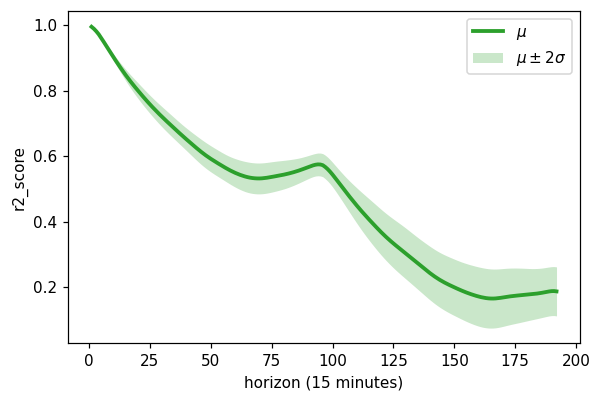

In [34]:
fig, ax = plt.subplots(1, 1, dpi=110)
y = np.array(scores[("r2_score", "mean")])
y_err = np.array(scores[("r2_score", "sem")])
ax.plot(
    np.arange(1, HORIZON+1), y, lw=2.5, c="tab:green", label="$\mu$"
)
ax.fill_between(
    np.arange(1, HORIZON+1), y-2*y_err, y+2*y_err, lw=0, color="tab:green", alpha=0.25, label="$\mu\pm 2\sigma$"
)
ax.set_xlabel("horizon (15 minutes)")
ax.set_ylabel("r2_score")
ax.legend();